# OCR(Optical Character Recognition)
|평가문항|상세기준|
|:-----:|:----:|
|1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?|목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.|
|2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?|평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.|
|3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?|최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.
|







활용 분야
* 우편번호 추출을 통한 우편물 관리
* 자동차 번호판 인식
* 모바일 기기를 사용한 명함 인식
* 신용카드 읽기를 이용한 결제 서비스
* 컨테이너 일련번호 인식을 이용한 스마트 선박 시스템

문자를 읽으려면?

문자의 존재를 **Detection** 하고, 어떤 문자인지 판독하는 **Recognition**하는 과정이 필요하다.

1. Detection
* Regression 방식
기준으로 하는 박스 대비 문자의 박스가 얼마나 차이나는지 학습한다.
* Segmentation 방식
픽셀단위로 해당 픽셀이 문자를 표현하는지 분류하는 문제이다. 
2. Recognition

* CRNN 모델
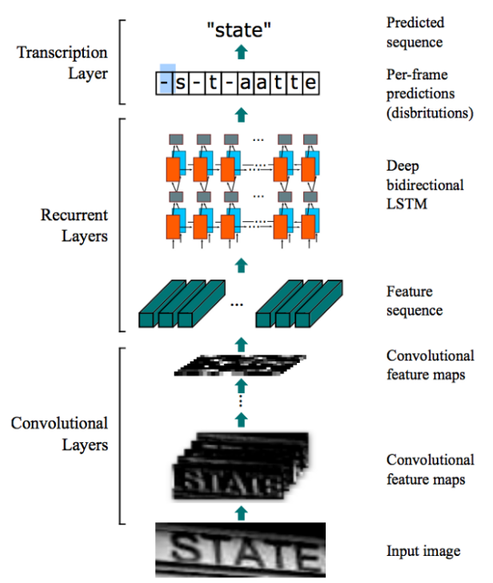


# Step1. 검증용 데이터셋 준비

In [1]:
import os

img_path = os.getenv('HOME')+'/aiffel/ocr_python/data/containers'
img_list = os.listdir(img_path)
containers = [file for file in img_list if file.endswith(".jpg")]
containers

['2.jpg', '1.jpg', '3.jpg']

여러 국가의 지폐로 데이터를 준비해보았습니다. 

# Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

## 1. keras-ocr

In [2]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [3]:
images = [keras_ocr.tools.read(os.path.join(img_path,c)) for c in containers]
prediction_groups = [pipeline.recognize([os.path.join(img_path,c)]) for c in containers]

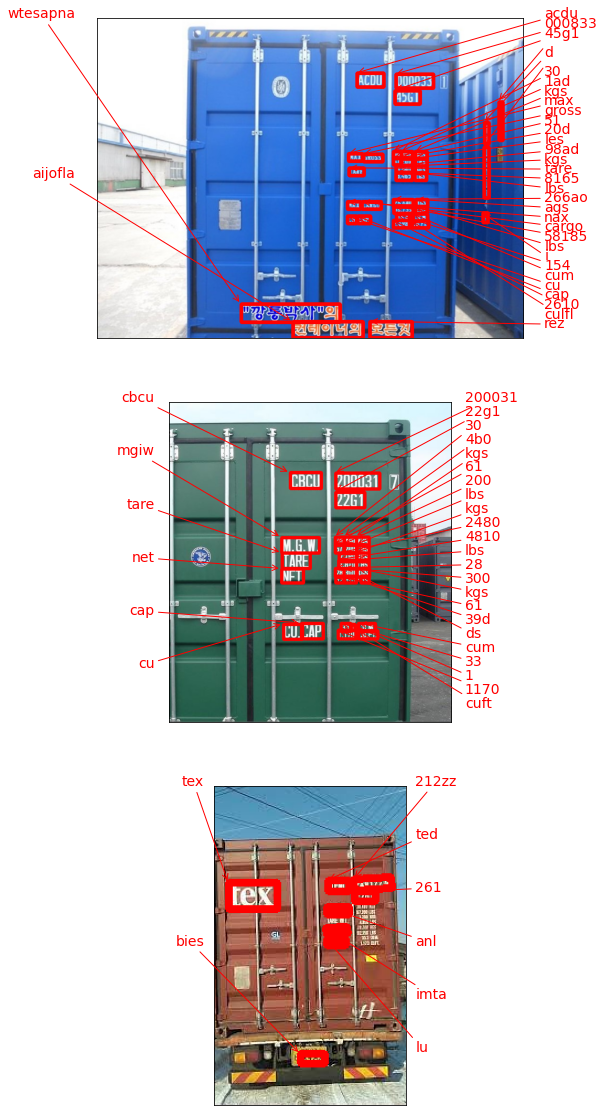

In [4]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 2. Pytesseract
### detection

In [14]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.jpg', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(3)}.jpg")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [15]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/data/containers'
img_file_path = work_dir + '/2.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 


In [16]:
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/data/containers/000.jpg


### recognition

In [18]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

iid

Done


# Step3. 테스트 결과 정리

* keras-ocr로 했을때 넘버를 잘 수집했다.
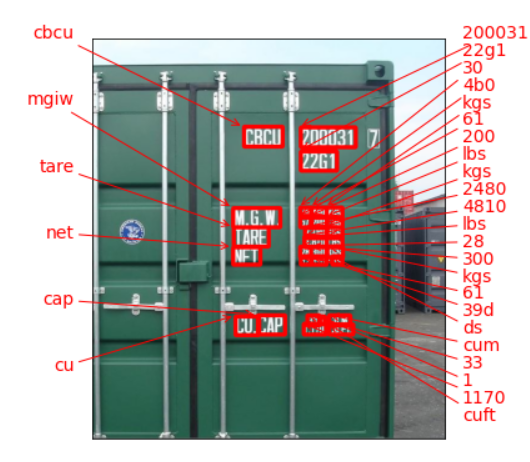

* Pytesseract로 했을때 왜인지모르게 넘버를 전혀 detection하지못한다...
나온거라곤 iid 하나뿐!!!ㅠㅠㅠ 다른 이미지로 했을 땐 잘되던데 뭐가 문제일까...





# Step4. 결과 분석과 결론 제시
ocr을 통해서 컨테이너의 넘버를 자동으로 수집하고자한다. 

중점적으로 볼 부분, 평가기준은 
1. 어느 업체의 컨테이너인지 **PREFIX**를 확인하고
2. 그 뒤로 나오는 7개의 숫자 **CHECK DIGIT**을 확인한다.




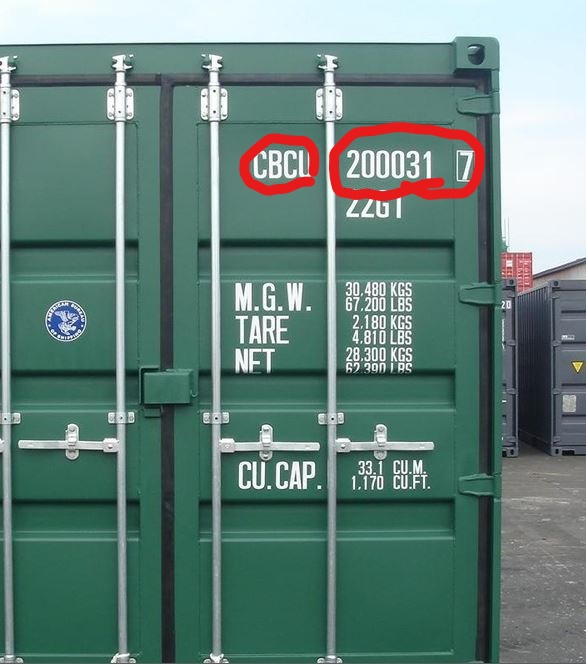

# 회고
처음에 위조지폐를 잡는 프로젝트로 진행하고자했지만 사실상 ocr을 통해서 얻을 수 있는건 지폐의 일련번호뿐이여서 다른 주제로 바꿨다. 아빠가 물류회사쪽에서 일해서 '컨테이너'라는 단어를 노드에서 보고 반가웠다.최근에 물류쪽에서 인공지능으로 무엇을 할 수있을까도 고민했었는데 이렇게 프로젝트를 진행하니 흥미로웠다. 그런데 지폐를 했을때는 모든것이 다 작동했는데 이상하게  Pytesseract에서 말썽이다. 인식을 못하는건지 내가 잘못설정한건지... 잘 모르겠다...ㅜㅜㅜ다른 사람들 말로는 구글api사용하면 인식률 엄청 좋다던데!! 다음에 한번 써봐야겠다. 아직은 쓸일이 없어서 지금 90일을 사용하면 아까울듯하다.